---
# MMD Final Exam - 12th of June 2023 - Stefan Cliff 2019230/449
---

The Dataset I have found and will be using is a Diabetes Prediction dataset from Kaggle
(https://www.kaggle.com/datasets/iammustafatz/diabetes-prediction-dataset)

I will be doing Logistic Regression on this dataset


## Setup/Imports

In [96]:
# install the pyspark library
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [97]:
# Importing my libraires
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix


# PySpark importing
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import *
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml import Pipeline

In [98]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Access files in Google Drive
file_path = '/content/drive/MyDrive/Colab Notebooks/Mining of Massive Datasets/Final Exam June/diabetes_prediction_dataset.csv'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Step 4 - Data Exploration

In [99]:
data = pd.read_csv(file_path)

data.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


In [100]:
data.shape

(100000, 9)

In [101]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.9+ MB


In [102]:
data.isnull().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64

In [103]:
data.describe()

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes
count,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,41.885856,0.07485,0.039420,27.320767,5.527507,138.058060,0.085000
std,22.516840,0.26315,0.194593,6.636783,1.070672,40.708136,0.278883
min,0.080000,0.00000,0.000000,10.010000,3.500000,80.000000,0.000000
25%,24.000000,0.00000,0.000000,23.630000,4.800000,100.000000,0.000000
50%,43.000000,0.00000,0.000000,27.320000,5.800000,140.000000,0.000000
75%,60.000000,0.00000,0.000000,29.580000,6.200000,159.000000,0.000000
max,80.000000,1.00000,1.000000,95.690000,9.000000,300.000000,1.000000


In [104]:
data['smoking_history'].unique()

array(['never', 'No Info', 'current', 'former', 'ever', 'not current'],
      dtype=object)

In [105]:
# Define the mapping dictionary
smoker_mapping = {
    'No Info': 0,
    'never': 1,
    'current': 2,
    'former': 3,
    'ever': 4,
    'not current': 5
}

# Apply the mapping to the desired column
data['smoking_history'] = data['smoking_history'].map(smoker_mapping)
data['smoking_history'].unique()

array([1, 0, 2, 3, 4, 5])

In [106]:
data['gender'].unique()

array(['Female', 'Male', 'Other'], dtype=object)

In [107]:
# Define the mapping dictionary
gender_mapping = {
    'Female': 1,
    'Male': 2,
    'Other': 3,
}

# Apply the mapping to the desired column
data['gender'] = data['gender'].map(gender_mapping)
data['gender'].unique()

array([1, 2, 3])

After setting up my new maps for the the previously text values in my dataset

In [108]:
data.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,1,80.0,0,1,1,25.19,6.6,140,0
1,1,54.0,0,0,0,27.32,6.6,80,0
2,2,28.0,0,0,1,27.32,5.7,158,0
3,1,36.0,0,0,2,23.45,5.0,155,0
4,2,76.0,1,1,2,20.14,4.8,155,0


In [109]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  int64  
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  int64  
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(6)
memory usage: 6.9 MB


## Step 5 - Logistic regression

In [110]:
from sklearn.model_selection import train_test_split

X = data.drop('diabetes', axis=1)  
y = data['diabetes']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [111]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()
logreg.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [112]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

y_pred = logreg.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


Accuracy: 0.9381
Precision: 0.7322134387351779
Recall: 0.4338407494145199
F1 Score: 0.5448529411764705


## Step 6 - Evaluation and Visualisation

Confusion Matrix: The confusion matrix provides a visual representation of the model's performance in terms of true positives, true negatives, false positives, and false negatives.

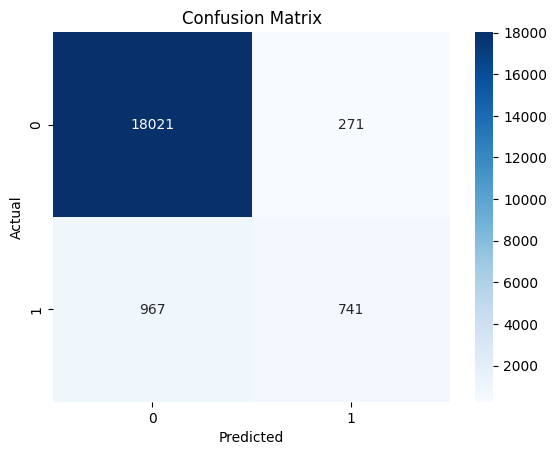

In [113]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

# Create a heatmap of the confusion matrix
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

ROC Curve: The Receiver Operating Characteristic (ROC) curve is a graphical representation of the model's performance across different probability thresholds. It shows the trade-off between true positive rate (sensitivity) and false positive rate (1 - specificity).

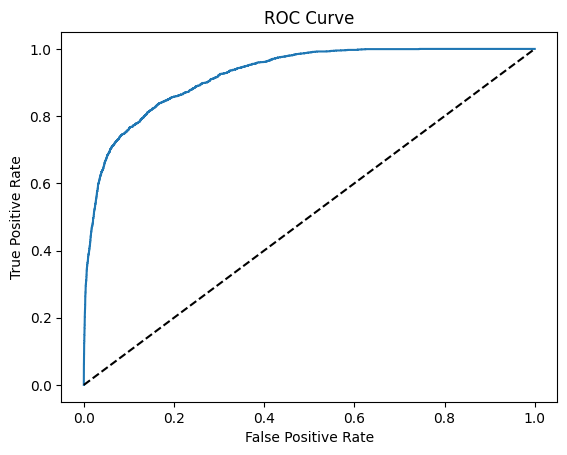


AUC: 0.9231721735253916


In [114]:
from sklearn.metrics import roc_curve, roc_auc_score

# Get the predicted probabilities for the positive class
y_pred_proba = logreg.predict_proba(X_test)[:, 1]

# Calculate the false positive rate, true positive rate, and threshold values
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Plot the ROC curve
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line representing random guessing
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

# Calculate the area under the ROC curve (AUC)
auc = roc_auc_score(y_test, y_pred_proba)
print("\nAUC:", auc)


Precision-Recall Curve: The precision-recall curve illustrates the trade-off between precision (positive predictive value) and recall (sensitivity) across different probability thresholds. It is useful when dealing with imbalanced datasets.

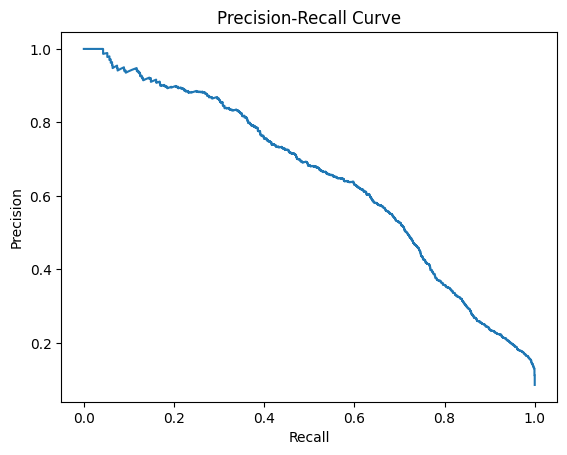


Average Precision: 0.6479190193939808


In [115]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# Get the precision, recall, and threshold values
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)

# Plot the precision-recall curve
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

# Calculate the average precision score
average_precision = average_precision_score(y_test, y_pred_proba)
print("\nAverage Precision:", average_precision)
